
## Driverless AI & H2O3 - python Client Tutorial with Lending Club Data


**Lending Club** publishes loan data periodically for public use. The anonymized data has information on different loans issued, such as loan_id, loan_amount, what loan grade, credit score etc., and also a **loan_status** variable that indicates whether a loan was _Fully Paid_ or _Charged Off_ (written off because of default).

In this tutorial, we use a python client to download the data from **Lending Club** website. The code then does some basic munging using Pandas, makes a connection to Driverless AI instance and then initiates a binary classification experiment using some inital experiment settings. In that process, we will also drop some target leakage columns, specify the target column, accuracy, time and interpretability settings, scorer etc.,

Before running the experiment, the data is split to training and test. At the end of the experiment, the test predictions and other model artifacts are then downloaded along with the model score (we are using AUC in this case). 


The first thing to do is to get the Driverless AI python client by following the steps here (if you don't have it already!)

http://docs.h2o.ai/driverless-ai/latest-stable/docs/userguide/python_install_client.html

#### Connect to Driverless AI instance 

Replace the **driverless_ai_host** string below with the correct IP address of the driverless AI instance. If you are using Puddle, then use _localhost_. The **username** and **password** should be the same as what you'd use to login to Driverless AI instance. If you are on Puddle, it will be 'h2oai' and the password shown in Puddle screen.


In [23]:
import h2oai_client
import numpy as np
import pandas as pd

import requests
import math
from sklearn import model_selection
from h2oai_client import Client, ModelParameters, InterpretParameters

address = 'http://<ip_address>:12345'
username = 'h2oai'  
password = '<password>'
h2oai = Client(address = address, username = username, password = password)

# make sure to use the same user name and password when signing in through the GUI

### Upload the Train and Test data to Driverless AI

In [24]:
import os
train_path = os.getcwd()+"/train_lc.csv.zip"
test_path = os.getcwd()+ "/test_lc.csv.zip"

h2oai.upload_dataset(train_path)
h2oai.upload_dataset(test_path)



['remeludi']

In [25]:
all_data_sets = h2oai.list_datasets(0,100)
all_data_sets = pd.DataFrame({
   "key": list(map(lambda x: x.key, all_data_sets))
  ,"name": list(map(lambda x: x.name, all_data_sets))
})


In [26]:
all_data_sets

,key,name
0,remeludi,test_lc.csv.zip
1,bopilohi,train_lc.csv.zip
2,cutidame,test_lc.csv.zip
3,dusagebi,train_lc.csv.zip
4,kupuliba,NHIRD Sepsis data0310.csv
5,fubobeba,churn_test.csv
6,punodesa,churn_train.csv


In [27]:

test_key = all_data_sets.key[0]
train_key = all_data_sets.key[1]
test_columns = h2oai.get_raw_data(test_key,0,1).headers
train_columns = h2oai.get_raw_data(train_key,0,2).headers


### Run an Experiment Preview in Driverless AI
Set the target col to **loan_status**, dropped cols to the list of target leakage cols + accuracy, time and interpretability settings of 1,1 and 8. Let's set the scorer to AUC etc., The resulting output will be the execution plan for the experiment, including algorithm selections, cross validation strategy, feature transformations that will be used as decided by the recipe.

In [28]:
target='loan_status'
exp_preview = h2oai.get_experiment_preview_sync(dataset_key= train_key, 
                                                validset_key='', 
                                                classification=True, 
                                                target_col=target,
                                                dropped_cols=[],
                                                is_time_series = False, 
                                                enable_gpus = True, 
                                                accuracy = 5, time = 1, interpretability = 5, 
                                                config_overrides="""
                                             enable_tensorflow="On"
                                             enable_tensorflow_textcnn="On"
                                             enable_tensorflow_textbigru="On"
                                             enable_tensorflow_charcnn="On"
                                         """)
exp_preview

['ACCURACY [5/10]:',
 '- Training data size: *34,030 rows, 41 cols*',
 '- Feature evolution: *[LightGBM, XGBoost]*, *1/3 validation split*',
 '- Final pipeline: *Ensemble (4 models), 4-fold CV*',
 '',
 'TIME [1/10]:',
 '- Feature evolution: *4 individuals*, up to *17 iterations*',
 '- Early stopping: disabled',
 '',
 'INTERPRETABILITY [5/10]:',
 '- Feature pre-pruning strategy: None',
 '- XGBoost Monotonicity constraints: disabled',
 '- Feature engineering search space (where applicable): [Clustering, Date, FrequencyEncoding, Identity, Interactions, IsHoliday, NumEncoding, OneHotEncoding, TargetEncoding, Text, TextBiGRU, TextCNN, TextCharCNN, TextLin, TruncatedSVD, WeightOfEvidence]',
 '',
 '[LightGBM, XGBoost] models to train:',
 '- Model and feature tuning: *16*',
 '- Feature evolution: *6*',
 '- Final pipeline: *4*']

### Run the Experiment 
Let's set the accuracy, time and interpretability settings of 1,1 and 8. Also drop the target leakage columns and set the scorer to AUC and make it a classification problem. We are also passing on the training and test data references to the python API which we uploaded a few steps before. 

Feel free to increase the the settings with higher accuracy and time. Lowering the interpretability will increase feature engineering efforts to get a better model!

In [ ]:
experiment = h2oai.start_experiment_sync(dataset_key=train_key,
                                         testset_key = test_key,
                                         target_col=target,
                                         dropped_cols=[],
                                         is_classification=True,
                                         accuracy=5,
                                         time=1,
                                         interpretability=5,
                                         scorer="AUC",
                                         enable_gpus=True,
                                         seed=1234,
                                         config_overrides="""
                                             enable_tensorflow="On"
                                             enable_tensorflow_textcnn="On"
                                             enable_tensorflow_textbigru="On"
                                             enable_tensorflow_charcnn="On"
                                         """
                                        )

#### Print Validation (from Training/Cross Validation) and Test Scores

In [90]:
print("Final Model Score on Validation Data: " + str(round(experiment.valid_score, 3)))
print("Final Model Score on Test Data: " + str(round(experiment.test_score, 3)))

Final Model Score on Validation Data: 0.71
Final Model Score on Test Data: 0.704


#### Visualize model score evolving over iterations

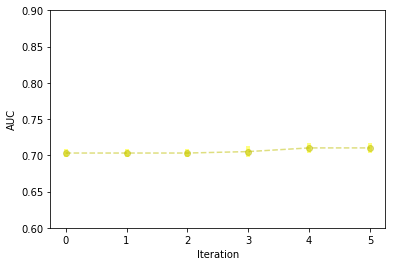

In [91]:
import matplotlib.pyplot as plt
%matplotlib inline

# Add scores from experiment iterations
iteration_data = h2oai.list_model_iteration_data(experiment.key, 0, len(experiment.iteration_data))
iterations = list(map(lambda iteration: iteration.iteration, iteration_data))
scores_mean = list(map(lambda iteration: iteration.score_mean, iteration_data))
scores_sd = list(map(lambda iteration: iteration.score_sd, iteration_data))

# Add score from final ensemble
iterations = iterations + [max(iterations) + 1]
scores_mean = scores_mean + [experiment.valid_score]
scores_sd = scores_sd + [experiment.valid_score_sd]

plt.figure()
plt.errorbar(iterations, scores_mean, yerr=scores_sd, color = "y", 
             ecolor='yellow', fmt = '--o', elinewidth = 4, alpha = 0.5)
plt.xlabel("Iteration")
plt.ylabel("AUC")
plt.ylim([0.6, .9])
plt.show();

#### Download the test predictions ...

In [33]:
h2oai.download(src_path=experiment.test_predictions_path, dest_dir=".")

'./test_preds.csv'

In [34]:
test_preds = pd.read_csv("./test_preds.csv")
test_preds.head()

,loan_status.Charged Off,loan_status.Fully Paid
0,0.127741,0.872259
1,0.209393,0.790607
2,0.067872,0.932128
3,0.090275,0.909725
4,0.141584,0.858417
